In [12]:
# Import packages

import numpy as np
import pandas as pd
import os, errno
import datetime
import uuid
import itertools
import yaml
import subprocess
import scipy.sparse as sp
from scipy.spatial.distance import squareform
from sklearn.decomposition import non_negative_factorization
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import sparsefuncs
from scipy.cluster.hierarchy import leaves_list
import matplotlib.pyplot as plt
from multiprocessing import Pool
import scanpy as sc
%matplotlib inline
from scipy.io import mmread
from IPython.display import Image
import anndata
import seaborn as sns
from scipy import stats

In [13]:
# Read in LFC df csv files

bt112_lfc_df = pd.read_csv('bt112_DRC_lfc_01122024.csv', index_col=0)
bt228_lfc_df = pd.read_csv('bt228_DRC_lfc_01122024.csv', index_col=0)
bt333_lfc_df = pd.read_csv('bt333_DRC_lfc_01122024.csv', index_col=0)

# Read in LFC df csv files

bt112_genes = pd.read_csv('BT112_de_genes_01252024.csv', index_col=0)
bt228_genes = pd.read_csv('BT228_de_genes_01252024.csv', index_col=0)
bt333_genes = pd.read_csv('BT333_de_genes_01252024.csv', index_col=0)

# Read in DRC assignment csv files

bt112_drc = pd.read_csv('bt112_DRC_assignment_01192024.csv', index_col=0)
bt228_drc = pd.read_csv('bt228_DRC_assignment_01192024.csv', index_col=0)
bt333_drc = pd.read_csv('bt333_DRC_assignment_01192024.csv', index_col=0)

In [14]:
de_genes = set([i[0] for i in bt112_genes.values.tolist()]).intersection(set([i[0] for i in bt228_genes.values.tolist()]))
de_genes = de_genes.intersection(set([i[0] for i in bt333_genes.values.tolist()]))

len(de_genes)

441

In [15]:
# Concatenate dataframes 

drc_names = []
cell_line = []

for i in range(1,bt112_lfc_df.shape[1]+1):
    drc_names.append('BT112_' + str(i))
    cell_line.append('BT112')
for i in range(1,bt228_lfc_df.shape[1]+1):
    drc_names.append('BT228_' + str(i))
    cell_line.append('BT228')
for i in range(1,bt333_lfc_df.shape[1]+1):
    drc_names.append('BT333_' + str(i))
    cell_line.append('BT333')
    
lfc_df = pd.concat([bt112_lfc_df,bt228_lfc_df,bt333_lfc_df],axis=1)
lfc_df.columns = drc_names
lfc_df

,BT112_1,BT112_2,BT112_3,BT112_4,BT112_5,BT112_6,BT112_7,BT112_8,BT112_9,BT112_10,...,BT333_16,BT333_17,BT333_18,BT333_19,BT333_20,BT333_21,BT333_22,BT333_23,BT333_24,BT333_25
RRP7BP,-0.331918,-0.268208,-0.164830,-0.212687,-0.189588,-0.102799,-0.232650,-0.177985,-0.036181,-0.084422,...,-0.102553,-0.105918,-0.067526,-0.086994,-0.082862,-0.096872,-0.097910,-0.121883,-0.122494,-0.047173
TULP4,-0.228447,-0.430173,-0.093579,-0.133452,-0.166163,-0.114159,-0.238929,-0.094378,-0.078107,-0.194185,...,0.067609,0.070474,0.072973,0.057648,-0.004686,-0.065624,0.052491,0.062229,0.080753,0.076622
MAP3K14,0.425852,-0.154187,-0.021759,0.075440,0.013685,-0.042315,0.049413,0.064243,-0.032983,0.123364,...,0.112950,0.110593,0.083017,0.132918,-0.016949,-0.021125,0.036854,0.063573,0.074887,0.049263
ZNFX1,-0.200047,0.124471,-0.023921,0.026045,0.044150,0.076410,0.023691,0.035925,0.047769,-0.123172,...,-0.079393,-0.049834,-0.111199,-0.110255,-0.010471,-0.046812,-0.042263,0.005914,-0.034285,-0.077827
TRIM25,-0.059534,-0.184253,0.038570,0.010690,-0.079139,-0.082420,-0.047613,-0.005714,-0.080240,0.043089,...,-0.478376,-0.499731,-0.263713,-0.518924,0.316934,-0.166584,-0.137046,-0.371343,-0.371878,-0.128220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REXO2,-0.461378,0.102905,-0.351369,-0.078685,0.166342,0.243086,0.145468,-0.015498,0.109230,-0.066237,...,-0.087828,-0.096358,-0.024168,-0.076105,0.090072,0.005626,-0.027984,-0.095154,-0.083883,-0.007617
YAP1,0.704438,-0.020114,-0.096194,-0.013354,-0.037924,-0.006600,-0.048905,-0.014786,-0.036082,-0.082180,...,0.204436,0.258634,0.024871,0.100333,-0.511206,-0.321033,0.056999,0.315038,0.251730,0.064100
SERINC5,-0.089586,0.344549,0.226620,-0.036019,0.044418,0.025121,0.048795,-0.044995,0.008429,0.118723,...,0.228229,0.242510,0.141047,0.235213,-0.063653,0.054480,0.124958,0.167933,0.185107,0.110175
NOC2L,-0.183929,-0.102301,-0.035217,-0.053591,-0.042563,-0.035431,-0.029529,-0.042615,-0.002238,0.002253,...,-0.113600,-0.090436,-0.103268,-0.129253,0.034575,0.022313,-0.044479,-0.057513,-0.086063,-0.064622


In [16]:
# Subset the lfc dataframe for DEGs 

df = pd.DataFrame(columns=lfc_df.columns,index=list(de_genes))

for gene in de_genes:
    df.loc[gene] = lfc_df[lfc_df.index==gene].values[0]
    
lfc_df = df.astype('float64')
lfc_df

,BT112_1,BT112_2,BT112_3,BT112_4,BT112_5,BT112_6,BT112_7,BT112_8,BT112_9,BT112_10,...,BT333_16,BT333_17,BT333_18,BT333_19,BT333_20,BT333_21,BT333_22,BT333_23,BT333_24,BT333_25
AHNAK,-0.146827,-0.042045,-0.146188,-0.008551,0.057150,0.075970,0.071286,0.011249,0.062694,0.013665,...,0.023859,0.036055,0.014472,0.021909,0.264889,0.235936,0.041283,0.026180,0.026462,0.021475
SORBS2,-0.255072,-0.090518,-0.090913,0.002451,0.060644,0.046552,0.058649,0.027262,0.096012,0.040156,...,-0.017007,-0.017380,0.000617,-0.014981,0.070272,0.031750,0.003904,-0.030915,-0.018986,0.004605
DLEU2,-0.074663,-0.291095,0.008422,-0.230129,-0.237517,-0.177095,-0.256310,-0.209164,-0.079693,0.178997,...,-0.080361,-0.067469,-0.086629,-0.110846,0.137398,0.028198,-0.005682,-0.036220,-0.045843,-0.041441
TANC1,-0.121946,-0.186385,-0.049414,-0.047409,-0.053655,-0.034301,-0.066656,-0.032421,-0.015603,0.036870,...,-0.035470,0.029003,-0.163673,-0.059256,-0.066037,0.029062,-0.103477,0.059052,-0.003859,-0.125888
EXT1,0.066863,-0.122082,-0.155338,-0.230052,-0.164143,-0.095642,-0.204222,-0.191331,-0.086480,0.236858,...,-0.216195,-0.185183,-0.231448,-0.234205,-0.079639,-0.123853,-0.167252,-0.100980,-0.162586,-0.201770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GRIPAP1,0.699683,-0.138272,-0.011550,-0.003373,-0.013102,-0.019906,-0.077886,0.010048,-0.045926,-0.064409,...,-0.048124,-0.029644,-0.056523,-0.080276,-0.016010,-0.049289,-0.009650,-0.013761,-0.020428,-0.016061
KCNN3,0.244203,0.320038,0.046936,0.012454,0.120835,0.114392,0.127822,0.017715,0.078560,0.157450,...,-0.000915,-0.033742,-0.000655,-0.011342,-0.398429,-0.214113,-0.040945,-0.040465,0.000980,-0.029157
FAM3C,0.019554,0.309154,-0.647418,0.022187,0.195841,0.241940,0.275048,0.053077,0.097930,-0.130244,...,0.044505,0.043346,0.022845,0.041820,-0.007938,0.062948,0.034574,0.025680,0.038466,0.016047
XPR1,-1.500490,-0.261192,-1.034125,-0.364985,-0.100770,0.035673,-0.096607,-0.269650,-0.087688,-0.488887,...,2.012249,1.403377,2.571581,2.512370,-0.042829,0.450901,1.319491,0.394093,1.215942,1.880735


# Shared PDCL DRC cluster analysis

In [17]:
# z-score across genes i.e. rows

lfc_df = stats.zscore(lfc_df, axis=0)  

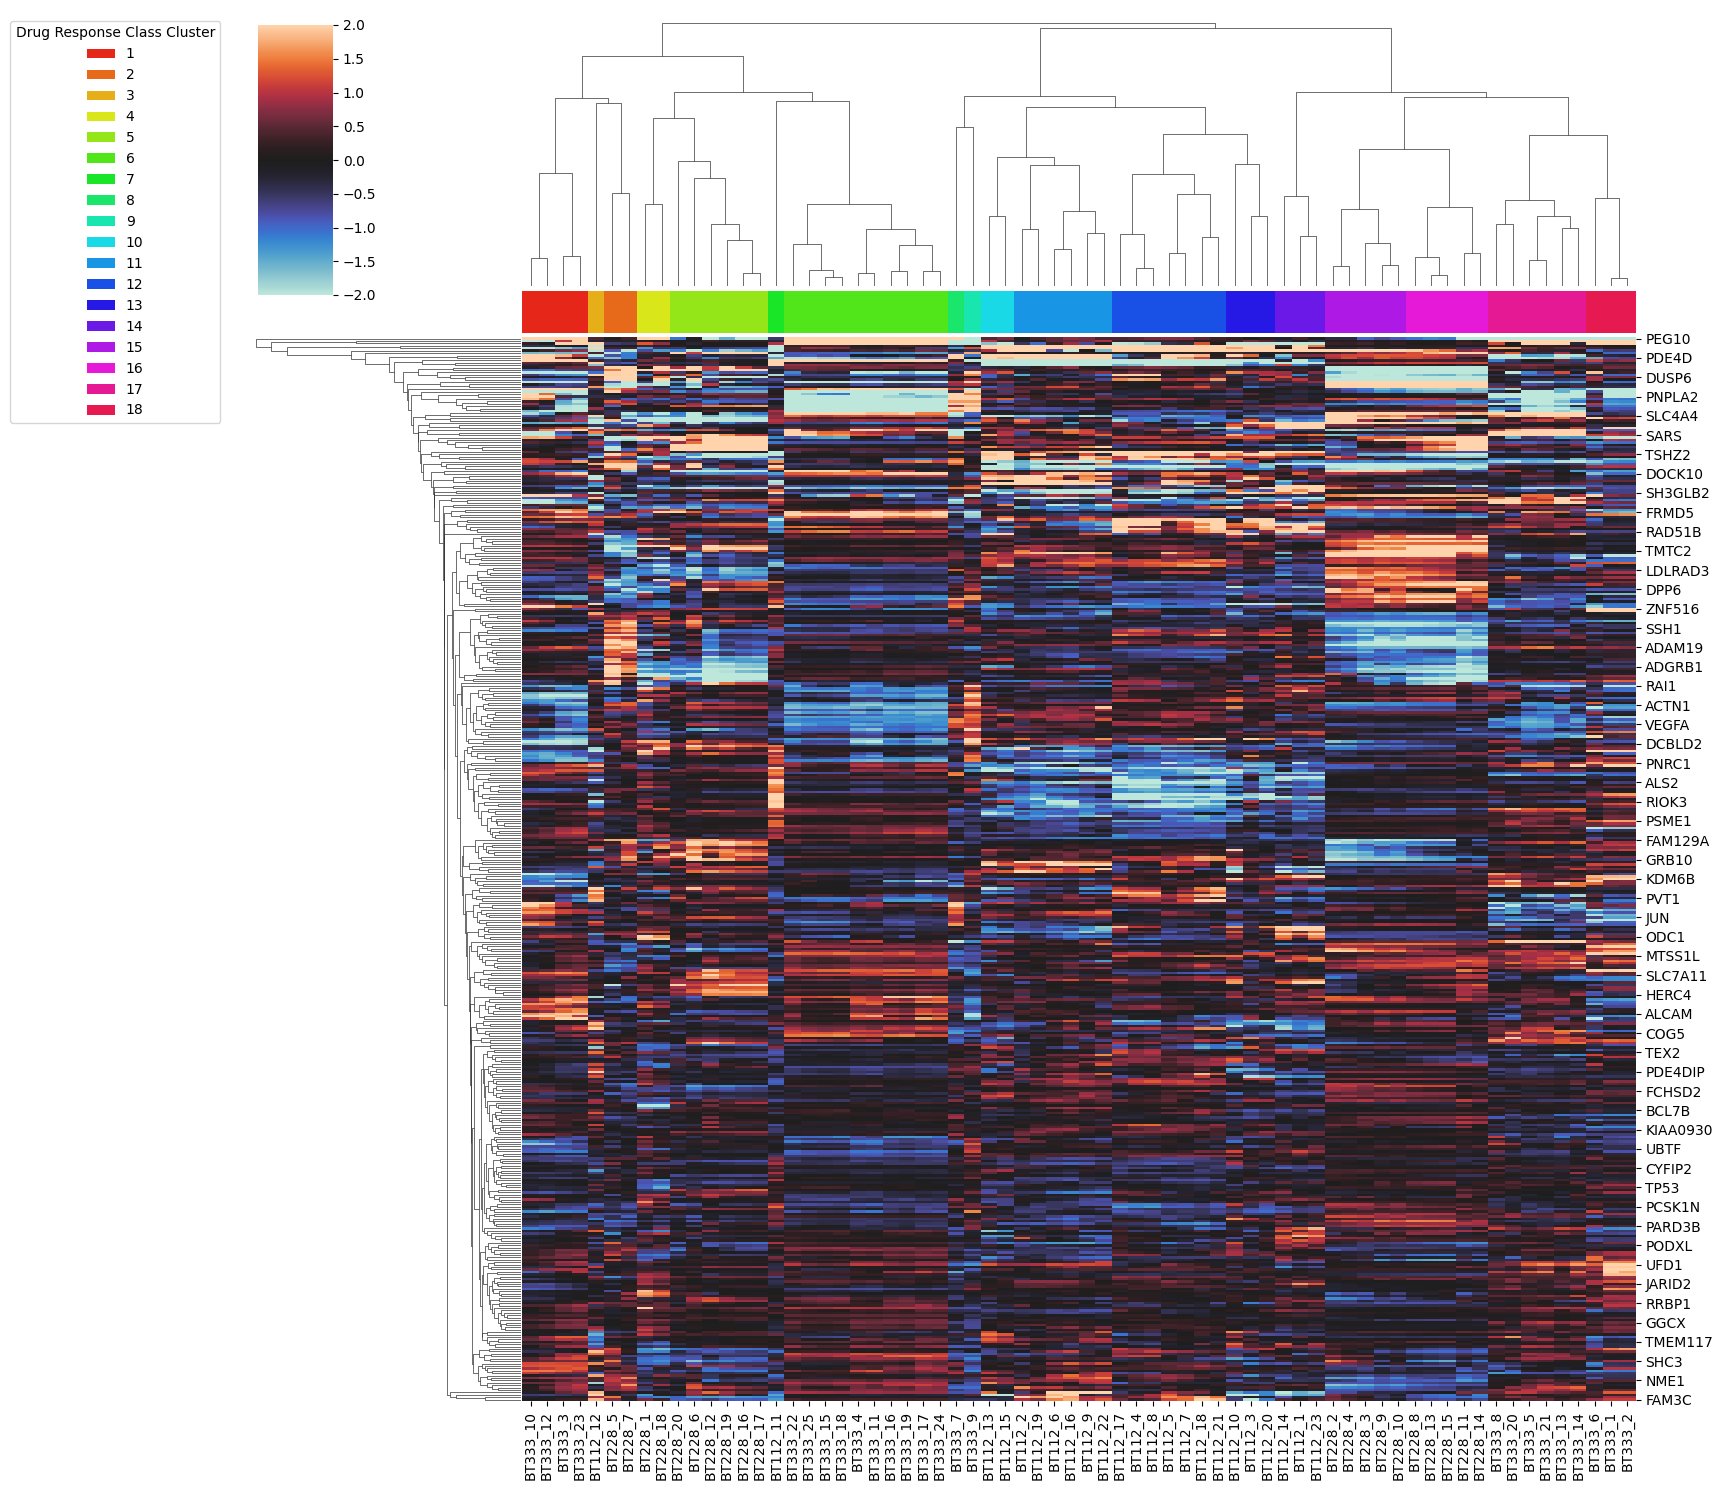

In [28]:
# CLUSTERMAP

from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from matplotlib.pyplot import gcf
from scipy.stats import zscore

cluster_method = 'complete'

col_linkage = hierarchy.linkage(
    distance.pdist(lfc_df.T), 
    method=cluster_method
)

col_labels = fcluster(col_linkage, t=20, criterion='distance')
lut = dict(zip(set(col_labels), sns.hls_palette(len(set(col_labels)), l=0.5, s=0.8)))
col = pd.DataFrame(col_labels)[0].map(lut)

g = sns.clustermap(
        lfc_df,
        cmap='icefire',
        xticklabels=True,
        col_linkage=col_linkage,
        col_colors = [col],
        figsize=(15,15),
        vmin=-2,
        vmax=2
)

for label in np.unique(col_labels):
    g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
l2 = g.ax_row_dendrogram.legend(title='Drug Response Class Cluster', loc="lower left",
                               bbox_to_anchor=(-0.15, 0.71), bbox_transform=gcf().transFigure,
                               ncol=1)

plt.show()

In [26]:
# Save the LFC DataFrame + clustering labels 

lfc_df.to_csv(
    'SharedPDCL_MrVI_multivariateDE_DRC_LFC_lfcANDpvalFiltered.csv',
    header=True,
    index=True
)

pd.DataFrame(col_labels, index=lfc_df.columns, columns=['DRC_Cluster']).to_csv(
    'SharedPDCL_MrVI_multivariateDE_DRC_HierarchicalClusters_lfcANDpvalFiltered.csv'
)

In [20]:
# shared PDCL DRC cluster labels 
drug_cluster = pd.DataFrame(col_labels,
                            index = lfc_df.columns,
                            columns = ['DRC cluster'])

# find drugs associated with each DRC in each PDCL 
DRC_drug_map = {key: [] for key in drug_cluster.index}

for i in range(len(bt112_drc)):
    drugname = bt112_drc.index[i][:-4]
    cluster = bt112_drc['cluster'][i]
    DRC_drug_map['BT112_'+str(cluster)].append(drugname)

for i in range(len(bt228_drc)):
    drugname = bt228_drc.index[i][:-4]
    cluster = bt228_drc['cluster'][i]
    DRC_drug_map['BT228_'+str(cluster)].append(drugname)
    
for i in range(len(bt333_drc)):
    drugname = bt333_drc.index[i][:-4]
    cluster = bt333_drc['cluster'][i]
    DRC_drug_map['BT333_'+str(cluster)].append(drugname)

for key in DRC_drug_map.keys():
    DRC_drug_map[key] = set(DRC_drug_map[key])

/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_61676/158549721.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster = bt112_drc['cluster'][i]
/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_61676/158549721.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster = bt228_drc['cluster'][i]
/var/folders/gq/297dtdk90zdck6656zjx1hc00000gn/T/ipykernel_61676/158549721.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

In [21]:
# Create a binary data frame for presence of drug in the response cluster

drug_name = pd.read_csv('LargeDrugScreen/BTline_20231106_drugname.tsv', header=None)
drug_name = np.unique(drug_name)

DRC_cluster_df = pd.DataFrame(0,
                              index=drug_name,
                              columns=np.arange(1,np.max(drug_cluster.values)+1))

# NOTE: i = shared DRC cluster
for i in range(1,len(drug_cluster)+1): 
    for DRC in drug_cluster[drug_cluster['DRC cluster'] == i].index:
        # print(DRC)
        # print(DRC_drug_map[DRC])
        for drug in DRC_drug_map[DRC]:
            DRC_cluster_df.loc[drug,i] = 1 
    # print('................')

DRC_cluster_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
AC480,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0
AEE788,1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
AG-1478,1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
AG-1557,1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
AG-18,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Varlitinib,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
WHI-P154,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
WZ3146,1,1,0,0,0,1,1,0,1,0,1,1,0,0,1,1,0,0
WZ4002,1,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0


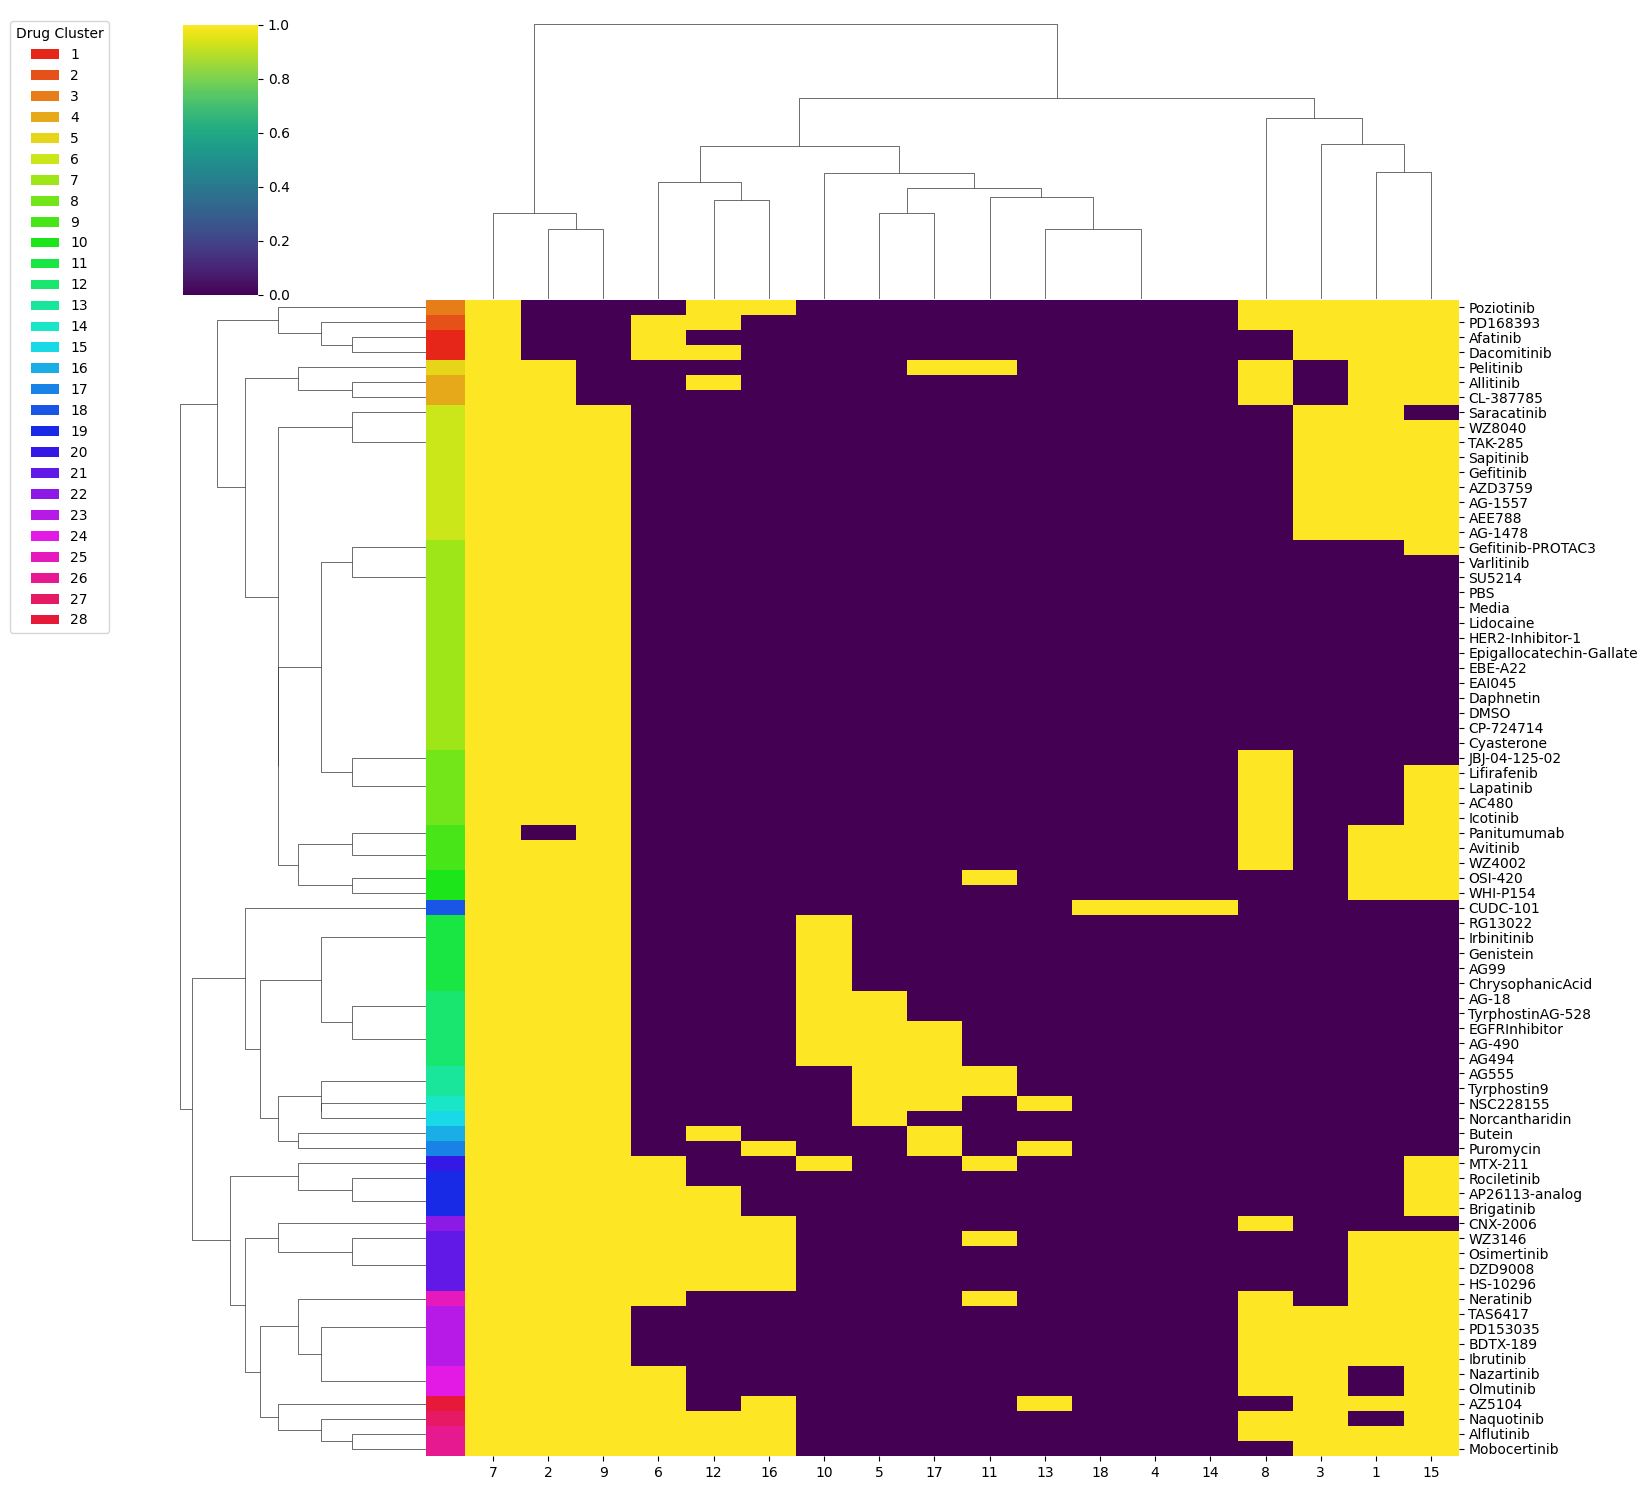

In [30]:
# CLUSTERMAP 

cluster_method = 'complete'

row_linkage = hierarchy.linkage(
    distance.pdist(DRC_cluster_df), 
    method=cluster_method
)

row_col_labels = fcluster(row_linkage, t=1, criterion='distance')
lut = dict(zip(set(row_col_labels), sns.hls_palette(len(set(row_col_labels)), l=0.5, s=0.8)))
row_col = pd.DataFrame(row_col_labels)[0].map(lut)

g = sns.clustermap(
        DRC_cluster_df,
        cmap='viridis',
        xticklabels=True,
        row_linkage=row_linkage,
        row_colors = [row_col],
        yticklabels=True,
        figsize=(15,15)
)

for label in np.unique(row_col_labels):
    g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
l2 = g.ax_row_dendrogram.legend(title='Drug Cluster', loc="lower left",
                               bbox_to_anchor=(-0.1, 0.57), bbox_transform=gcf().transFigure)

plt.show()

In [25]:
# Save the drug-DRC binary membership DataFrame + clustering labels 

DRC_cluster_df.to_csv(
    'SharedPDCL_MrVI_Drug_DRC_BinaryMembership_Matrix_lfcANDpvalFiltered.csv',
    header=True,
    index=True
)

pd.DataFrame(row_col_labels, index=DRC_cluster_df.index, columns=['Drug_Cluster']).to_csv(
    'SharedPDCL_MrVI_Drug_DRC_BinaryMembership_HierarchicalClusters_lfcANDpvalFiltered.csv'
)

# UMAP from LFCs

In [23]:
# Convert pd.DataFrame() to sc.AnnData()

adata = sc.AnnData(lfc_df.T)
adata.obs['cell_line'] = cell_line
adata

AnnData object with n_obs × n_vars = 68 × 441
    obs: 'cell_line'

2024-01-25 15:37:32,327 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-01-25 15:37:32,498 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-01-25 15:37:32,506 - harmonypy - INFO - Iteration 1 of 10
2024-01-25 15:37:32,573 - harmonypy - INFO - Iteration 2 of 10
2024-01-25 15:37:32,595 - harmonypy - INFO - Iteration 3 of 10
2024-01-25 15:37:32,614 - harmonypy - INFO - Converged after 3 iterations
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/nicholashou27/anaconda3/envs/run-models-test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None'

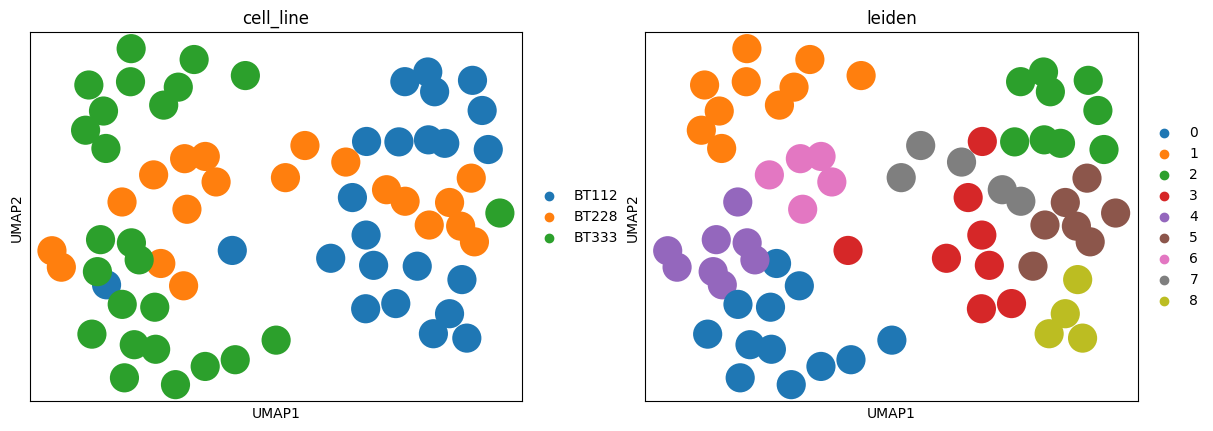

In [24]:
# UMAP dim reduction
 
sc.pp.pca(adata, use_highly_variable=False) 
sc.external.pp.harmony_integrate(adata, 'cell_line')
sc.pp.neighbors(adata, n_neighbors=20,use_rep='X_pca_harmony')
# sc.external.pp.bbknn(adata, batch_key = 'cell_line')
sc.tl.umap(adata, min_dist=0.5)
sc.tl.leiden(adata, resolution=2)

sc.pl.umap(adata, color=['cell_line','leiden'])